In [8]:
import pandas as pd
import numpy as np
from scipy.stats import zscore
import matplotlib.pyplot as plt
from visualize_training.hmm import HMM
from visualize_training.visualize import visualize_dag, visualize_avg_log_likelihood, visualize_hmm_loss
from visualize_training.utils import training_run_json_to_csv, save_model, munge_data
pd.set_option('display.max_rows', 500)

In [2]:
parent_dir = "all_metrics"

In [3]:
def pizza_clock_plot(attn, parent_dir):
    
    seed_0 = pd.read_csv(parent_dir + f"/modular_clock_pizza_run_{attn}/lr0.001_adamw_seed0_scaling1.0.csv")
    seed_1 = pd.read_csv(parent_dir + f"/modular_clock_pizza_run_{attn}/lr0.001_adamw_seed1_scaling1.0.csv")
    seed_2 = pd.read_csv(parent_dir + f"/modular_clock_pizza_run_{attn}/lr0.001_adamw_seed2_scaling1.0.csv")
    seed_3 = pd.read_csv(parent_dir + f"/modular_clock_pizza_run_{attn}/lr0.001_adamw_seed3_scaling1.0.csv")
    
    avg_grad_sym = (seed_0['grad_sym'] + seed_1['grad_sym'] + seed_2['grad_sym'] + seed_3['grad_sym'])/4
    avg_dist_irr = (seed_0['dist_irr'] + seed_1['dist_irr'] + seed_2['dist_irr'] + seed_3['dist_irr'])/4
    avg_eval_loss = (seed_0['eval_loss'] +seed_1['eval_loss'] + seed_2['eval_loss'] + seed_3['eval_loss'])/4
    
    fig, axs = plt.subplots(nrows=1, ncols=2,figsize=(15, 7))
    ax2 = axs[0].twinx()
    axs[0].plot(seed_0['epoch'], avg_grad_sym, 'g-', label = "grad_sym")
    axs[0].plot(seed_0['epoch'], avg_dist_irr, 'b-', label = "dist_irr")
    ax2.plot(seed_0['epoch'], avg_eval_loss, 'r-', label = "eval_loss")

    axs[0].set_xlabel("Epoch")
    axs[0].set_ylabel("grad sym / dist irr")
    ax2.set_ylabel("eval loss")
    axs[0].legend()
    plt.title(f"attention = {attn}")
    
    
    # fig, ax3 = plt.subplots()
    axs[1].scatter(avg_dist_irr, avg_grad_sym)
    axs[1].set_xlabel("dist_irr")
    axs[1].set_ylabel("grad sym")
    plt.show()

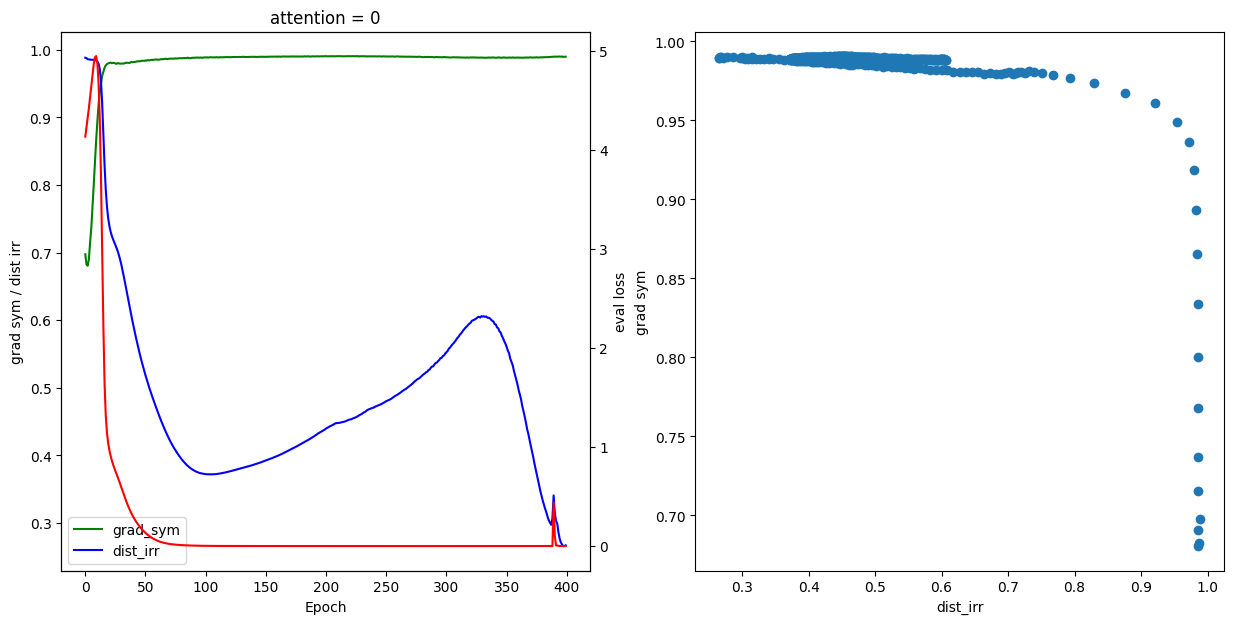

In [4]:
pizza_clock_plot('0',parent_dir)

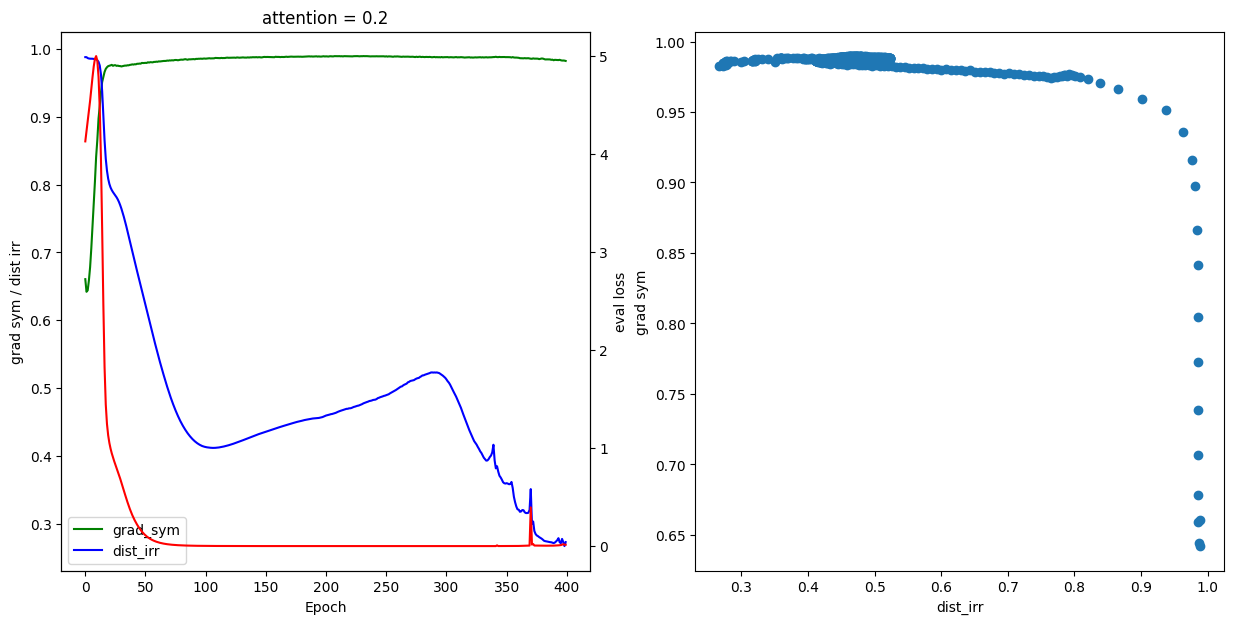

In [5]:
pizza_clock_plot("0.2",parent_dir)

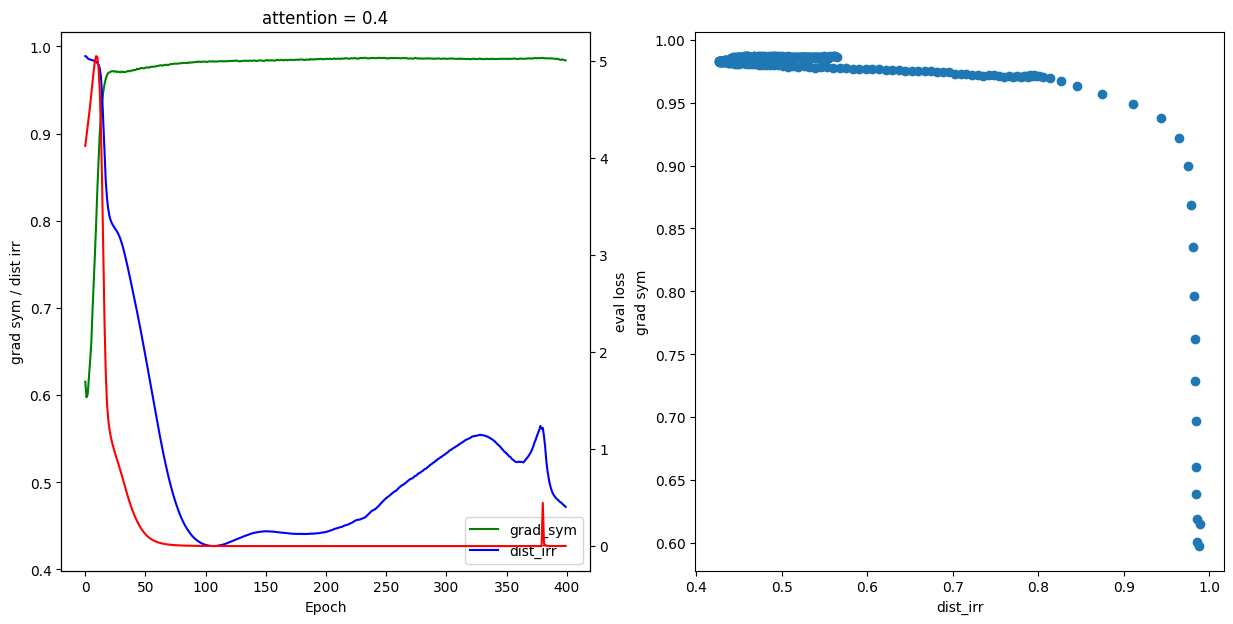

In [6]:
pizza_clock_plot("0.4",parent_dir)

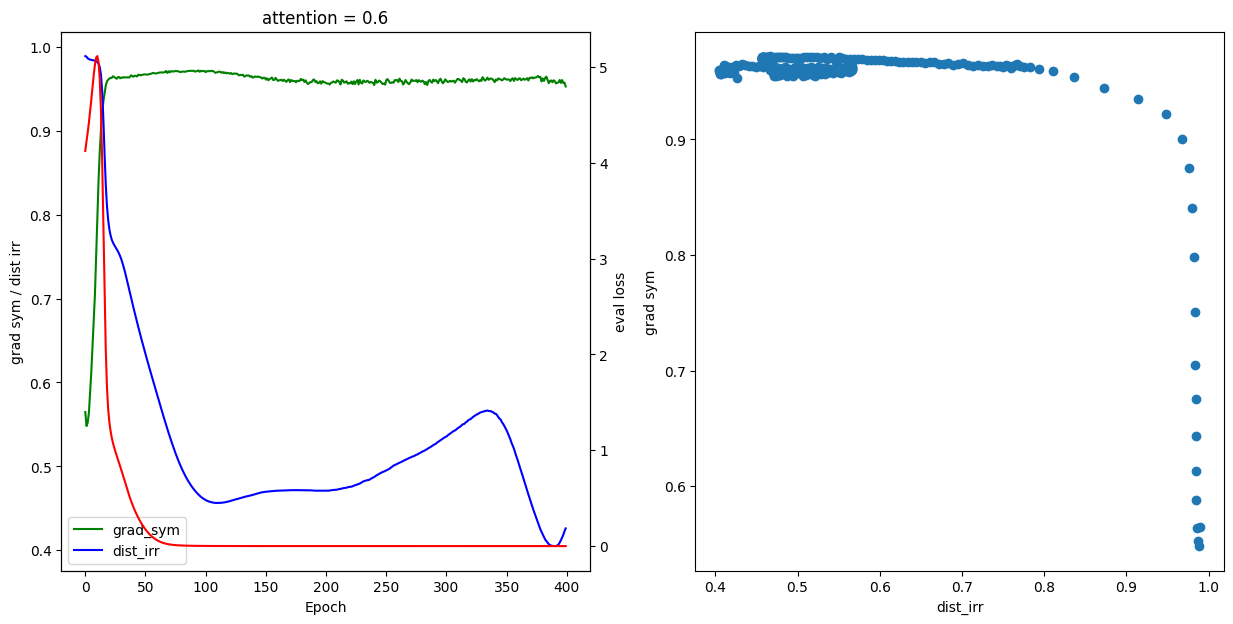

In [7]:
pizza_clock_plot("0.6",parent_dir)

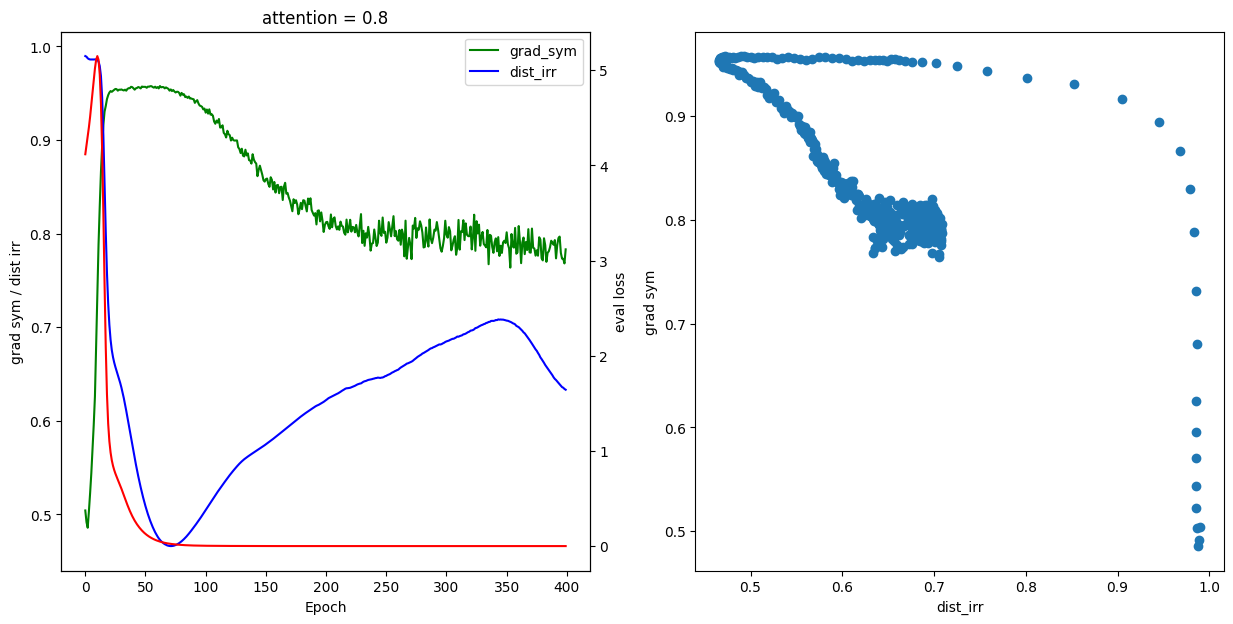

In [8]:
pizza_clock_plot("0.8",parent_dir)

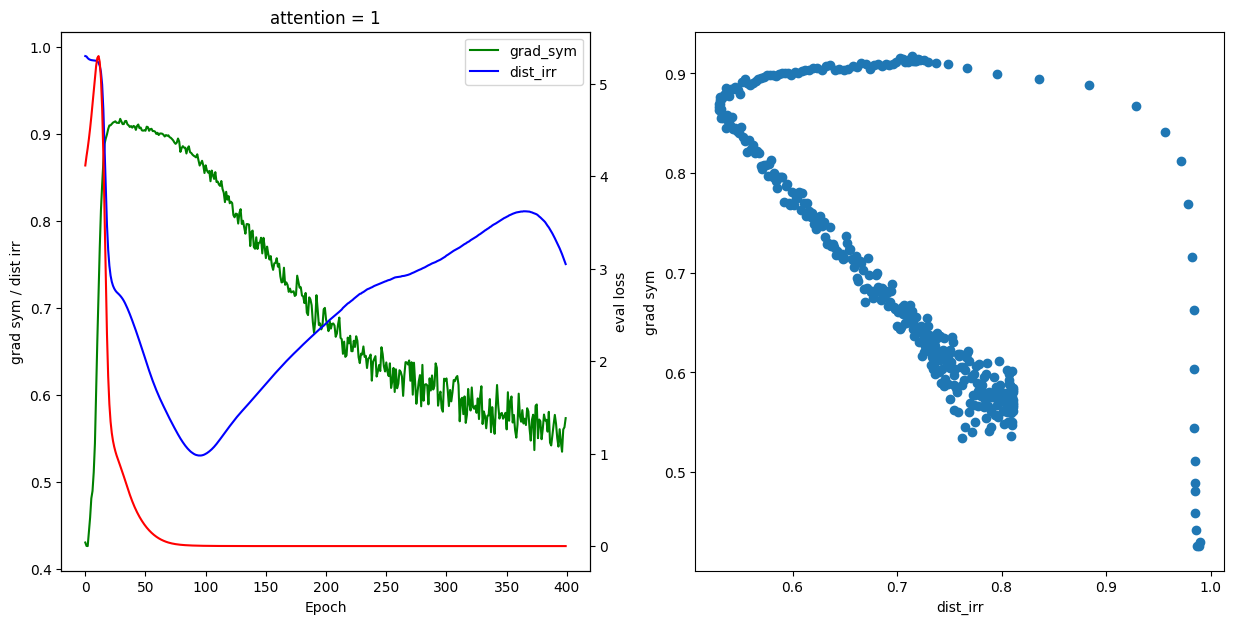

In [9]:
pizza_clock_plot("1",parent_dir)

- if grad sym is more than 0.8, its a pizza
- if grad sym less than 0.8, check for dist irr, if its more than 0.6, then its a clock
- if dist irr less than 0.6, its a pizza

### model with all metrics, attention = 0

In [18]:
max_components = 8
cov_type = "diag"
n_seeds = 4
n_iter = 100
attn = 0
cols = ['l1', 'l2', 'trace', 'spectral', 'code_sparsity',
       'computational_sparsity', 'mean_lambda', 'variance_lambda', 'mean_w',
       'median_w', 'var_w', 'mean_b', 'median_b', 'var_b','grad_sym',
       'dist_irr', 'train_loss', 'eval_loss', 'train_accuracy',
       'eval_accuracy']

first_n = 400
hmm_model = HMM(max_components, cov_type, n_seeds, n_iter)
data_dir = parent_dir + f"/modular_clock_pizza_run_{attn}/"
hmm_output = hmm_model.get_avg_log_likelihood(data_dir, cols)

visualize_avg_log_likelihood(hmm_output,"all_cols - modular_clock_pizza_run_0")

model_path = data_dir + '/model_all_metrics'
save_model(model_path,hmm_output)

n_components = 2
model_path = data_dir + '/model_all_metrics.pkl'
model, data, best_predictions, lengths = munge_data(hmm_model, model_path, data_dir, cols, n_components)

phases = list(set(hmm_model.best_model.predict(data, lengths=lengths)))
state_transitions = hmm_model.feature_importance(cols, data, best_predictions,phases,lengths)
best_model_transmat = model.transmat_

visualize_dag(best_model_transmat, edge_hover_dict = state_transitions)

all_metrics/modular_clock_pizza_run_0/
['all_metrics/modular_clock_pizza_run_0/lr0.001_adamw_seed2_scaling1.0.csv', 'all_metrics/modular_clock_pizza_run_0/lr0.001_adamw_seed3_scaling1.0.csv', 'all_metrics/modular_clock_pizza_run_0/lr0.001_adamw_seed1_scaling1.0.csv', 'all_metrics/modular_clock_pizza_run_0/lr0.001_adamw_seed0_scaling1.0.csv']


100%|██████████| 8/8 [00:05<00:00,  1.35it/s]


all_metrics/modular_clock_pizza_run_0/
['all_metrics/modular_clock_pizza_run_0/lr0.001_adamw_seed2_scaling1.0.csv', 'all_metrics/modular_clock_pizza_run_0/lr0.001_adamw_seed3_scaling1.0.csv', 'all_metrics/modular_clock_pizza_run_0/lr0.001_adamw_seed1_scaling1.0.csv', 'all_metrics/modular_clock_pizza_run_0/lr0.001_adamw_seed0_scaling1.0.csv']
-8542.245571777434


In [20]:
hmm_model.best_model

GaussianHMM(n_components=8, n_iter=100)

In [19]:
hmm_output['bics']

[22942.675113436853,
 7488.913226996867,
 12230.724733336669,
 19972.232318449584,
 20395.175293633067,
 19031.158208851568,
 36904.841960588106,
 37595.28333797625]

In [38]:
random_seed = 0
optimizer = "adamw"
lr = 0.001
scaling = 1.0
attn = 0
data_dir = parent_dir + f"/modular_clock_pizza_run_{attn}/"


training_run = pd.read_csv(f'{data_dir}lr{lr}_{optimizer}_seed{random_seed}_scaling{scaling}.csv')
data  = np.apply_along_axis(zscore, 0, training_run[cols].to_numpy())
training_run['phases']= hmm_output['best_models'][1].predict(data) + 1
# training_run['phases']= hmm_model.best_model.predict(data)

visualize_hmm_loss(training_run,phase_col = 'phases', epoch_col='epoch', loss_col='l2')

In [39]:
visualize_hmm_loss(training_run,phase_col = 'phases', epoch_col='epoch', loss_col='dist_irr')

In [40]:
visualize_hmm_loss(training_run,phase_col = 'phases', epoch_col='epoch', loss_col='grad_sym')

In [41]:
visualize_hmm_loss(training_run,phase_col = 'phases', epoch_col='epoch', loss_col='eval_loss')

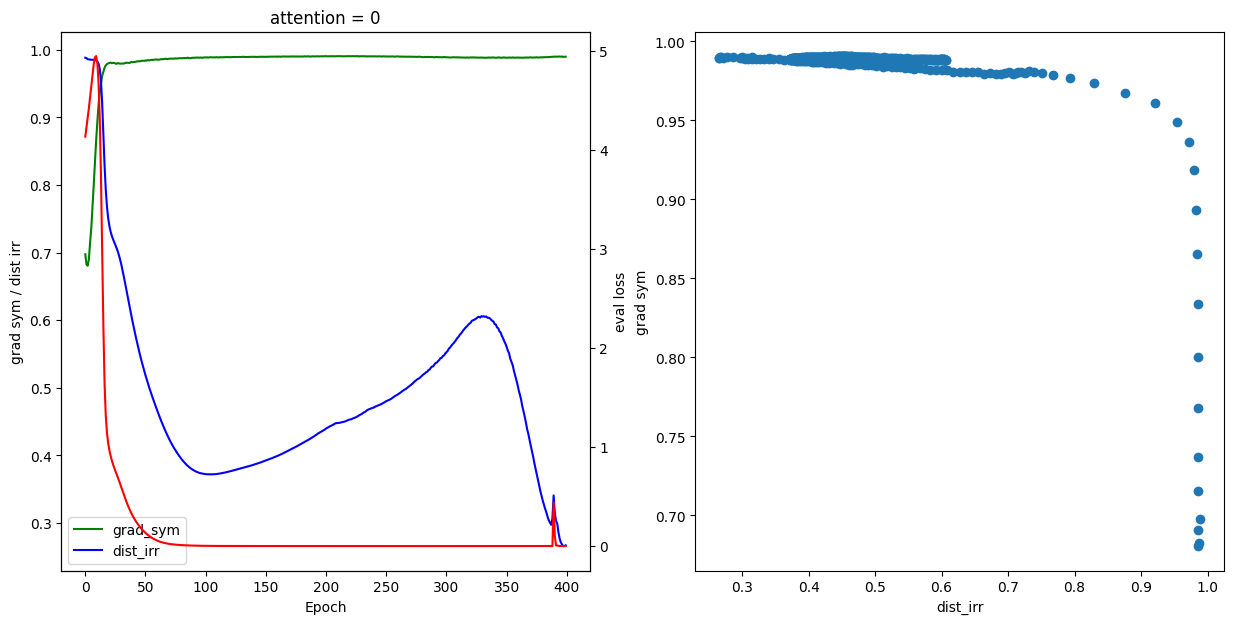

In [23]:
pizza_clock_plot('0',parent_dir)

### model with pizza clock metrics, attention = 0

In [29]:
max_components = 8
cov_type = "diag"
n_seeds = 4
n_iter = 10
attn = 0
cols = ['grad_sym',
       'dist_irr']

first_n = 400
hmm_model = HMM(max_components, cov_type, n_seeds, n_iter)
data_dir = parent_dir + f"/modular_clock_pizza_run_{attn}/"
hmm_output = hmm_model.get_avg_log_likelihood(data_dir, cols)

visualize_avg_log_likelihood(hmm_output,"pizza_cols - modular_clock_pizza_run_0")

model_path = data_dir + '/model_pizza_clock_metrics'
save_model(model_path,hmm_output)

all_metrics/modular_clock_pizza_run_0/
['all_metrics/modular_clock_pizza_run_0/lr0.001_adamw_seed2_scaling1.0.csv', 'all_metrics/modular_clock_pizza_run_0/lr0.001_adamw_seed3_scaling1.0.csv', 'all_metrics/modular_clock_pizza_run_0/lr0.001_adamw_seed1_scaling1.0.csv', 'all_metrics/modular_clock_pizza_run_0/lr0.001_adamw_seed0_scaling1.0.csv']


100%|██████████| 8/8 [00:00<00:00,  9.89it/s]


In [42]:
n_components = 6
model_path = data_dir + '/model_pizza_clock_metrics.pkl'
model, data, best_predictions, lengths = munge_data(hmm_model, model_path, data_dir, cols, n_components)

phases = list(set(hmm_model.best_model.predict(data, lengths=lengths)))
state_transitions = hmm_model.feature_importance(cols, data, best_predictions,phases,lengths)
best_model_transmat = model.transmat_

visualize_dag(best_model_transmat, edge_hover_dict = state_transitions)

all_metrics/modular_clock_pizza_run_0/
['all_metrics/modular_clock_pizza_run_0/lr0.001_adamw_seed2_scaling1.0.csv', 'all_metrics/modular_clock_pizza_run_0/lr0.001_adamw_seed3_scaling1.0.csv', 'all_metrics/modular_clock_pizza_run_0/lr0.001_adamw_seed1_scaling1.0.csv', 'all_metrics/modular_clock_pizza_run_0/lr0.001_adamw_seed0_scaling1.0.csv']
2344.300601713403


In [32]:
hmm_output['best_models'][5]

GaussianHMM(n_components=6)

In [43]:
random_seed = 0
optimizer = "adamw"
lr = 0.001
scaling = 1.0
attn = 0
data_dir = parent_dir + f"/modular_clock_pizza_run_{attn}/"


training_run = pd.read_csv(f'{data_dir}lr{lr}_{optimizer}_seed{random_seed}_scaling{scaling}.csv')
data  = np.apply_along_axis(zscore, 0, training_run[cols].to_numpy())
training_run['phases']= hmm_output['best_models'][5].predict(data) + 1
# training_run['phases']= hmm_model.best_model.predict(data)

visualize_hmm_loss(training_run,phase_col = 'phases', epoch_col='epoch', loss_col='l2')

In [44]:
visualize_hmm_loss(training_run,phase_col = 'phases', epoch_col='epoch', loss_col='dist_irr')

In [45]:
visualize_hmm_loss(training_run,phase_col = 'phases', epoch_col='epoch', loss_col='eval_loss')

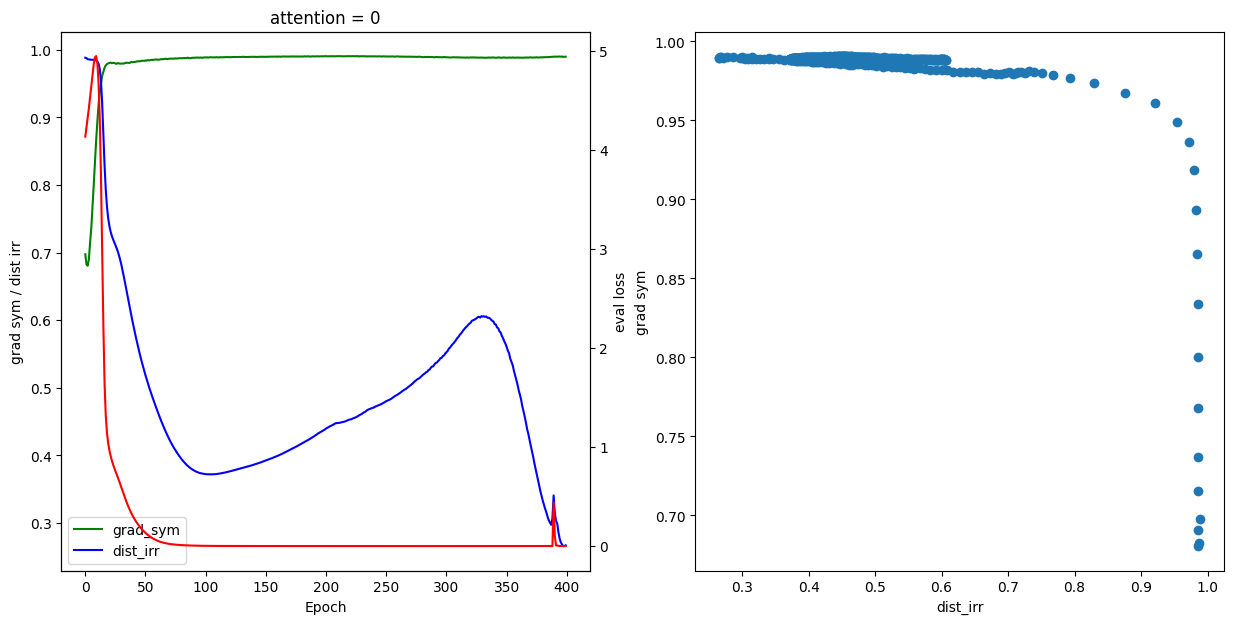

In [35]:
pizza_clock_plot('0',parent_dir)

### model with all metrics, attention = 1

In [46]:
max_components = 8
cov_type = "diag"
n_seeds = 4
n_iter = 200
attn = 1
cols = ['l1', 'l2', 'trace', 'spectral', 'code_sparsity',
       'computational_sparsity', 'mean_lambda', 'variance_lambda', 'mean_w',
       'median_w', 'var_w', 'mean_b', 'median_b', 'var_b','grad_sym',
       'dist_irr', 'train_loss', 'eval_loss', 'train_accuracy',
       'eval_accuracy']

first_n = 400
hmm_model = HMM(max_components, cov_type, n_seeds, n_iter)
data_dir = parent_dir + f"/modular_clock_pizza_run_{attn}/"
hmm_output = hmm_model.get_avg_log_likelihood(data_dir, cols)

visualize_avg_log_likelihood(hmm_output,"all_cols - modular_clock_pizza_run_0")

model_path = data_dir + '/model_all_metrics'
save_model(model_path,hmm_output)

all_metrics/modular_clock_pizza_run_1/
['all_metrics/modular_clock_pizza_run_1/lr0.001_adamw_seed2_scaling1.0.csv', 'all_metrics/modular_clock_pizza_run_1/lr0.001_adamw_seed3_scaling1.0.csv', 'all_metrics/modular_clock_pizza_run_1/lr0.001_adamw_seed1_scaling1.0.csv', 'all_metrics/modular_clock_pizza_run_1/lr0.001_adamw_seed0_scaling1.0.csv']


 88%|████████▊ | 7/8 [00:04<00:00,  1.18it/s]Model is not converging.  Current: 5642.061661248887 is not greater than 5642.062147261863. Delta is -0.00048601297658024123
Model is not converging.  Current: 9676.99070194138 is not greater than 9677.019545949077. Delta is -0.02884400769653439
100%|██████████| 8/8 [00:05<00:00,  1.35it/s]


In [58]:
hmm_model.best_model

GaussianHMM(n_components=8, n_iter=200)

In [47]:
n_components = 4
model_path = data_dir + '/model_all_metrics.pkl'
model, data, best_predictions, lengths = munge_data(hmm_model, model_path, data_dir, cols, n_components)

phases = list(set(hmm_model.best_model.predict(data, lengths=lengths)))
state_transitions = hmm_model.feature_importance(cols, data, best_predictions,phases,lengths)
best_model_transmat = model.transmat_

visualize_dag(best_model_transmat, edge_hover_dict = state_transitions)

all_metrics/modular_clock_pizza_run_1/
['all_metrics/modular_clock_pizza_run_1/lr0.001_adamw_seed2_scaling1.0.csv', 'all_metrics/modular_clock_pizza_run_1/lr0.001_adamw_seed3_scaling1.0.csv', 'all_metrics/modular_clock_pizza_run_1/lr0.001_adamw_seed1_scaling1.0.csv', 'all_metrics/modular_clock_pizza_run_1/lr0.001_adamw_seed0_scaling1.0.csv']
-2036.009452482925


In [55]:
hmm_model.best_model

GaussianHMM(n_components=8, n_iter=200)

In [48]:
random_seed = 0
optimizer = "adamw"
lr = 0.001
scaling = 1.0
attn = 1
data_dir = parent_dir + f"/modular_clock_pizza_run_{attn}/"


training_run = pd.read_csv(f'{data_dir}lr{lr}_{optimizer}_seed{random_seed}_scaling{scaling}.csv')
data  = np.apply_along_axis(zscore, 0, training_run[cols].to_numpy())
training_run['phases']= hmm_output['best_models'][3].predict(data) + 1

visualize_hmm_loss(training_run,phase_col = 'phases', epoch_col='epoch', loss_col='l2')

In [49]:
visualize_hmm_loss(training_run,phase_col = 'phases', epoch_col='epoch', loss_col='dist_irr')

In [53]:
visualize_hmm_loss(training_run,phase_col = 'phases', epoch_col='epoch', loss_col='grad_sym')

In [54]:
visualize_hmm_loss(training_run,phase_col = 'phases', epoch_col='epoch', loss_col='var_w')

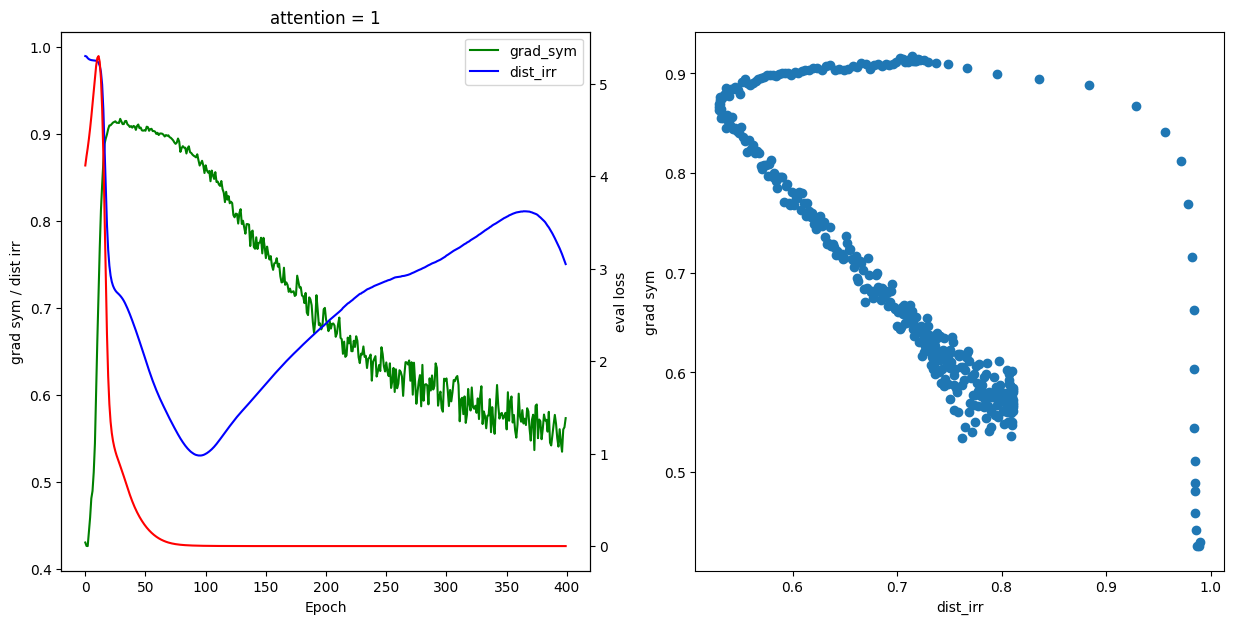

In [72]:
pizza_clock_plot("1",parent_dir)

### model with pizza - clock metrics, attention = 1

In [13]:
max_components = 8
cov_type = "diag"
n_seeds = 4
n_iter = 10
attn = 1
cols = ['grad_sym',
       'dist_irr']

first_n = 400
hmm_model = HMM(max_components, cov_type, n_seeds, n_iter)
data_dir = parent_dir + f"/modular_clock_pizza_run_{attn}/"
hmm_output = hmm_model.get_avg_log_likelihood(data_dir, cols)

visualize_avg_log_likelihood(hmm_output,"all_cols - modular_clock_pizza_run_0")

model_path = data_dir + '/model_pizza_clock_metrics'
save_model(model_path,hmm_output)

n_components = 4
model_path = data_dir + '/model_pizza_clock_metrics.pkl'
model, data, best_predictions, lengths = munge_data(hmm_model, model_path, data_dir, cols, n_components)

phases = list(set(hmm_model.best_model.predict(data, lengths=lengths)))
state_transitions = hmm_model.feature_importance(cols, data, best_predictions,phases,lengths)
best_model_transmat = model.transmat_

visualize_dag(best_model_transmat, edge_hover_dict = state_transitions)

all_metrics/modular_clock_pizza_run_1/
['all_metrics/modular_clock_pizza_run_1/lr0.001_adamw_seed2_scaling1.0.csv', 'all_metrics/modular_clock_pizza_run_1/lr0.001_adamw_seed3_scaling1.0.csv', 'all_metrics/modular_clock_pizza_run_1/lr0.001_adamw_seed1_scaling1.0.csv', 'all_metrics/modular_clock_pizza_run_1/lr0.001_adamw_seed0_scaling1.0.csv']


100%|██████████| 8/8 [00:00<00:00,  9.37it/s]


all_metrics/modular_clock_pizza_run_1/
['all_metrics/modular_clock_pizza_run_1/lr0.001_adamw_seed2_scaling1.0.csv', 'all_metrics/modular_clock_pizza_run_1/lr0.001_adamw_seed3_scaling1.0.csv', 'all_metrics/modular_clock_pizza_run_1/lr0.001_adamw_seed1_scaling1.0.csv', 'all_metrics/modular_clock_pizza_run_1/lr0.001_adamw_seed0_scaling1.0.csv']
-1763.5455397518058
